###### Assignemnt: Bayesian Convolutional Network with pyro

**Objective:** Implement, train and evaluate a Bayesian Lenet5 model on the MNIST dataset. 

**Requirements:**

- Use `torchvision.datasets.MNIST` to obtain the training and test data. Only use digits 4 and 9 (discard the others)
- Implement a bayesian neural network using `pyro` based on the Lenet5 convolutional architecture
- Use a bernoulli likelihood, a diagonal normal for the approximate posterior and a diagonal normal prior. Use the Mean Field Trace ELBO
- Evaluate the performance of the BNN using precision/recall curves and uncertainty calibration plots [2, 3, 4]
- Study the influence of the scale of the prior and the initial scale of the approximate posterior
- Compare your best bayesian model with a Deterministic Lenet5 
- Discuss your results! 


**References**
1. https://www.kaggle.com/blurredmachine/lenet-architecture-a-complete-guide
2. https://arxiv.org/pdf/1703.04977.pdf (Section 5.1)
3. https://arxiv.org/pdf/2007.06823.pdf (Section 9)
4. https://arxiv.org/pdf/1706.04599.pdf 

**Deadline**

17:30, June 16th, 2021


In [1]:
#try to do a simple netowrk to visualize epistemic uncertanty
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import torch
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pyro
display(pyro.__version__)
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

np.random.seed(66)
torch.manual_seed(66)
pyro.set_rng_seed(66) # Fo

'1.6.0'

In [2]:
def getIdxForLabels(dataset, labels):
    mask = dataset.targets == labels[0]
    for label in labels[1:]:
        mask |= dataset.targets == label
    return np.where(mask)

def renameLabelsInOrder(dataset, labels):
    i=0
    for label in labels:
        dataset.targets[dataset.targets == label] = i
        i+=1

mnist_train = torchvision.datasets.MNIST('./Datasets', train=True, download=True,
                                        transform=torchvision.transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST('./Datasets', train=False, download=True,
                                        transform=torchvision.transforms.ToTensor())
keepClasses = [4, 9]

train_idx = getIdxForLabels(mnist_train, keepClasses)
test_idx = getIdxForLabels(mnist_test, keepClasses)

train_dataset = Subset(mnist_train, train_idx[0])
test_dataset = Subset(mnist_test, test_idx[0])

renameLabelsInOrder(mnist_train, keepClasses)
renameLabelsInOrder(mnist_test, keepClasses)


print(len(train_dataset), " elements for training.")
print(len(test_dataset), " elements for testing.")

11791  elements for training.
1991  elements for testing.


/home/newt/.local/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


<IPython.core.display.Javascript object>


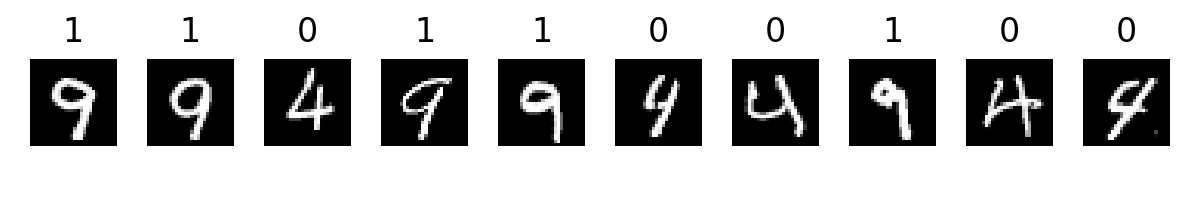

In [3]:
fig, ax = plt.subplots(1, 10, figsize=(6, 1), tight_layout=True)
for i in range(10):
    image, label = train_dataset[np.random.randint(len(train_dataset))]
    ax[i].imshow(image.numpy()[0, :, :], cmap=plt.cm.Greys_r)
    ax[i].axis('off')
    ax[i].set_title(label)

In [5]:
from torch.utils.data import DataLoader, SubsetRandomSampler

validationSize = 0.85
trainBatchSize = 128
validBatchSize = 128
testBatchSize = 256



idx = list(range(len(train_dataset)))
np.random.shuffle(idx)
split = int(validationSize*len(idx))

train_loader = DataLoader(train_dataset, batch_size=trainBatchSize, drop_last=False,
                          sampler=SubsetRandomSampler(idx[:split]))

valid_loader = DataLoader(train_dataset, batch_size=validBatchSize, drop_last=False,
                          sampler=SubsetRandomSampler(idx[split:]))

test_loader = DataLoader(test_dataset, batch_size=testBatchSize, drop_last=False,
                          shuffle=True)

<IPython.core.display.Javascript object>


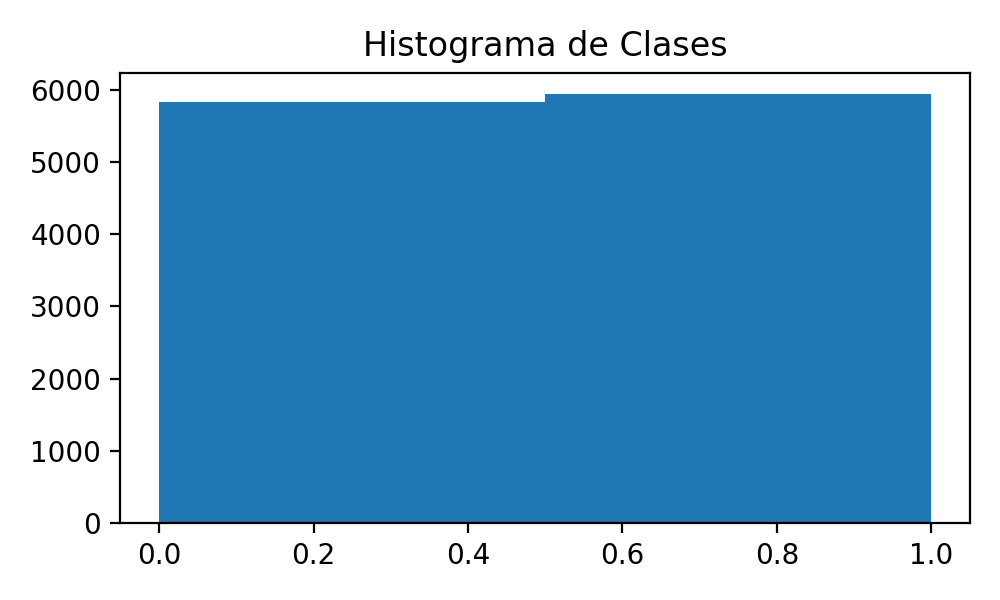

In [7]:
fig, ax = plt.subplots(figsize=(5, 3), tight_layout=True)
ax.hist(train_dataset.dataset.targets[train_dataset.indices].numpy(), bins=2)
ax.set_title("Histograma de Clases");

In [8]:
from NeuralNetworks import Lenet5Deterministic
deterministicModel = Lenet5Deterministic()

In [9]:
deterministicLearningRate = 3e-4

loss = nn.BCELoss()
optimizer = torch.optim.Adam(deterministicModel.parameters(), lr=deterministicLearningRate)

def train_loop(dataloader, model, loss_fn, optimizer, n_samples):
    size = n_samples
    epochLoss = 0
    nSamples = 0
    for batch, (X, y) in enumerate((dataloader)):
        # Compute prediction and loss
        y = y.type(torch.float)
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epochLoss += loss.item()
        nSamples += len(X)

    return epochLoss/nSamples
            

def valid_loop(dataloader, model, loss_fn, n_samples):
    size = n_samples
    test_loss, correct = 0, 0
    epochLoss = 0
    nSamples = 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            y = y.type(torch.float)
            test_loss += loss_fn(pred, y).item()
            
            correct += (torch.round(pred) == y).type(torch.float).sum().item()
            epochLoss += test_loss
            nSamples += len(X)

    test_loss /= size
    correct /= size
    print(f"         Validation Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}", end='\r')
    return epochLoss/nSamples
    
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    print(size)
    with torch.no_grad():
        for X, y in dataloader:
            y = y.type(torch.float)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (torch.round(pred) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

<IPython.core.display.Javascript object>


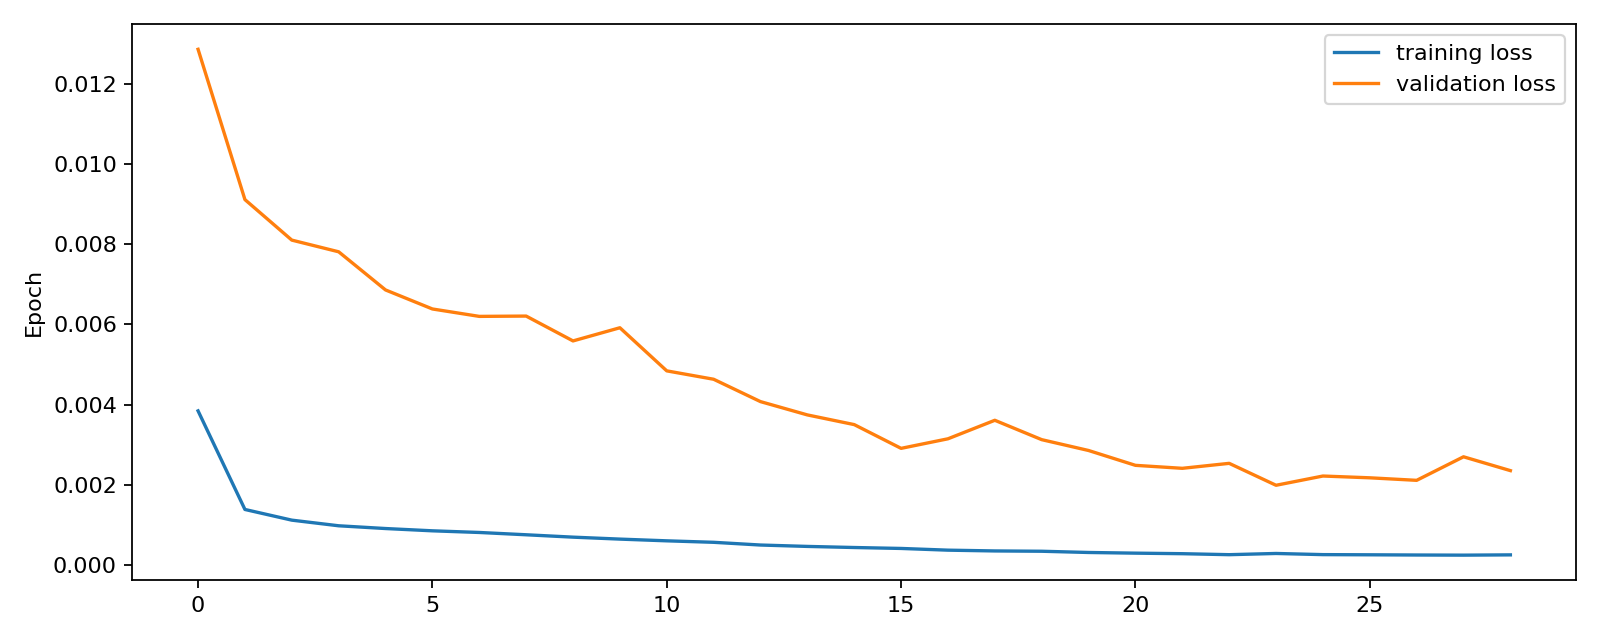

In [10]:
fig, ax = plt.subplots(figsize=(10, 4), tight_layout=True, dpi=80)

def update_plot(k, trainingLosses, validLosses):
    ax.cla()
    ax.plot(range(k), trainingLosses[:k], label="training loss")
    ax.plot(range(k), validLosses[:k], label="validation loss")

    #ax.set_yscale('log')
    ax.set_ylabel('Loss')
    ax.set_ylabel('Epoch')
    ax.legend()
    fig.canvas.draw()

In [11]:
from IPython.display import display, clear_output

epochs = 30

trainingLosses = np.zeros(epochs)
validLosses = np.zeros(epochs)

for t in range(epochs):
    #clear_output(wait=True)
    print(f"Epoch {t+1} ", end='\r')
    trainingLosses[t] = train_loop(train_loader, deterministicModel, loss, optimizer, split)
    validLosses[t] = valid_loop(valid_loader, deterministicModel, loss, len(train_loader.dataset)-split)
    update_plot(t, trainingLosses, validLosses)
    

test_loop(test_loader, deterministicModel, loss)


print("Done!")

1991     Validation Error: Accuracy: 98.8%, Avg loss: 0.000267
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.000092 

Done!


In [12]:
def getCorrectAnswersIdx(decisions, y):
    hits = (decisions == y)
    return np.where(hits == True)[0]

def getCollapsedDecision(samples):
    return (samples.mean(dim=0).round())

In [13]:
from NeuralNetworks import Lenet5Bayesian
bayesianModel = Lenet5Bayesian(prior_scale=1., isFEBayesian=True, prior_scaleFE=3.)

<IPython.core.display.Javascript object>


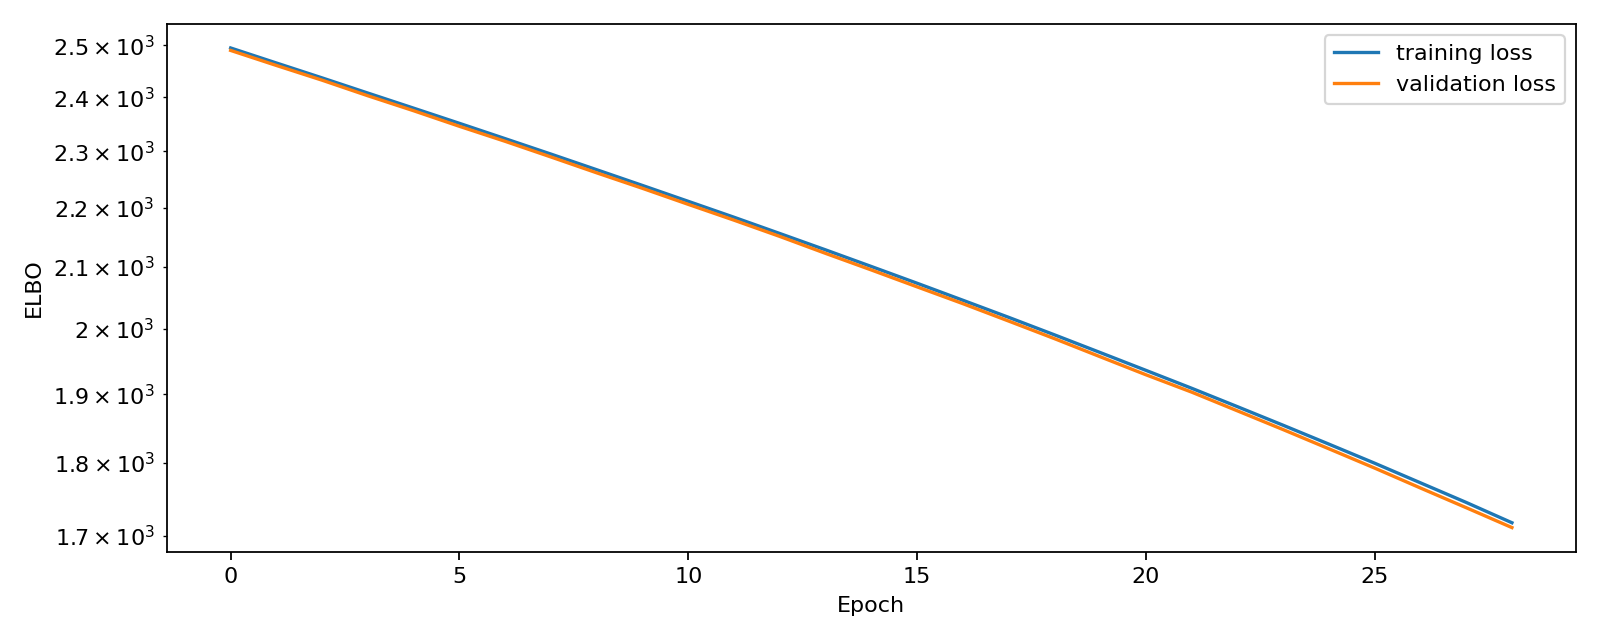

In [14]:
pyro.enable_validation(True)
fig, ax = plt.subplots(figsize=(10, 4), tight_layout=True, dpi=80)

def update_plot(k, trainingLosses, validLosses):
    ax.cla()
    ax.plot(range(k), trainingLosses[:k], label="training loss")
    ax.plot(range(k), validLosses[:k], label="validation loss")

    ax.set_yscale('log')
    ax.set_ylabel('ELBO')
    ax.set_xlabel('Epoch')
    ax.legend()
    fig.canvas.draw()

In [15]:
# Turn this on for additional debugging
pyro.enable_validation(False) 
pyro.clear_param_store() 
epochs = 30

# Create a guide
from pyro.infer.autoguide import AutoDiagonalNormal
guide = AutoDiagonalNormal(bayesianModel, init_scale=1.01e-3)
predictive = pyro.infer.Predictive(bayesianModel, guide=guide, num_samples=100)
# Create SVI object
svi = pyro.infer.SVI(bayesianModel, guide, 
                     optim=pyro.optim.ClippedAdam({'lr':1e-3, 'clip_norm':1.0}), # Optimizer
                     loss=pyro.infer.TraceMeanField_ELBO()) # Loss function 

epoch_loss = np.zeros(shape=(epochs,))
validLoss = np.zeros(shape=(epochs,))


for k in tqdm(range(len(epoch_loss))):
    acumloss = 0
    n = 0
    for batch, (X, y) in enumerate(train_loader):
        acumloss += svi.step(x=X, y=y.type(torch.float)) # Actual training step
        n+=(X.shape[0])
    epoch_loss[k] = acumloss/n

    #update_plot(k, epoch_loss, validLoss)   
    res = 0
    total = 0
    acumloss = 0
    for batch, (X, y) in enumerate(valid_loader):
        acumloss += svi.evaluate_loss(X, y.type(torch.float))
        #validLoss[k] = loss / len(X)
        ans = getCollapsedDecision(predictive(X)['obs'].detach())
        correct = getCorrectAnswersIdx(ans, y)
        res += len(correct)
        total += X.shape[0]
    validLoss[k] = acumloss/total
    #print(epoch_loss, validLoss)
    update_plot(k, epoch_loss, validLoss)
    print("Validation Score:", res/total*100, end='\r')
 
            

  0%|          | 0/30 [00:00<?, ?it/s]

Validation Score: 89.25946862634257
Validation Score: 93.95138496325607
Validation Score: 95.36461277557943
Validation Score: 96.1560203504805
Validation Score: 96.83436970039571
Validation Score: 97.23007348784624
Validation Score: 97.45618993781797
Validation Score: 97.73883550028265
Validation Score: 97.79536461277559
Validation Score: 97.73883550028265
Validation Score: 97.79536461277559
Validation Score: 98.02148106274731
Validation Score: 98.13453928773318
Validation Score: 98.36065573770492
Validation Score: 98.41718485019784
Validation Score: 98.19106840022611
Validation Score: 98.4737139626908
Validation Score: 98.64330130016958
Validation Score: 98.75635952515546
Validation Score: 98.69983041266252
Validation Score: 98.75635952515546
Validation Score: 98.81288863764838
Validation Score: 98.86941775014132
Validation Score: 98.81288863764838
Validation Score: 99.03900508762013
Validation Score: 98.81288863764838
Validation Score: 98.58677218767666
Validation Score: 98.925946862

Cuando el modelo se entrena demasiado (ya sea durante muchas epocas o con un learning rate alto) el score baja a 0.5 por algun motivo. Que sucede cuando las redes bayesianas se sobreajustan?

In [16]:
predictive = pyro.infer.Predictive(bayesianModel, guide=guide, num_samples=100)

res = 0
total = 0
errors= []
samples = []
with torch.no_grad():
    for X, y in tqdm(test_loader):
        out = predictive(X)['obs'].detach()
        hitormiss = (out.mean(dim=0).round() == y)
        
        total += X.shape[0]
        fails = np.where(hitormiss == False)        
        correct = np.where(hitormiss == True)
        res += len(correct[0])
        for error in X[fails[0]]:
            errors.append(error)
        for error in out.numpy().T[fails[0]]:
            samples.append(error)
        
        print("Test score:", res/total*100, end='\r')


  0%|          | 0/8 [00:00<?, ?it/s]

21


<IPython.core.display.Javascript object>


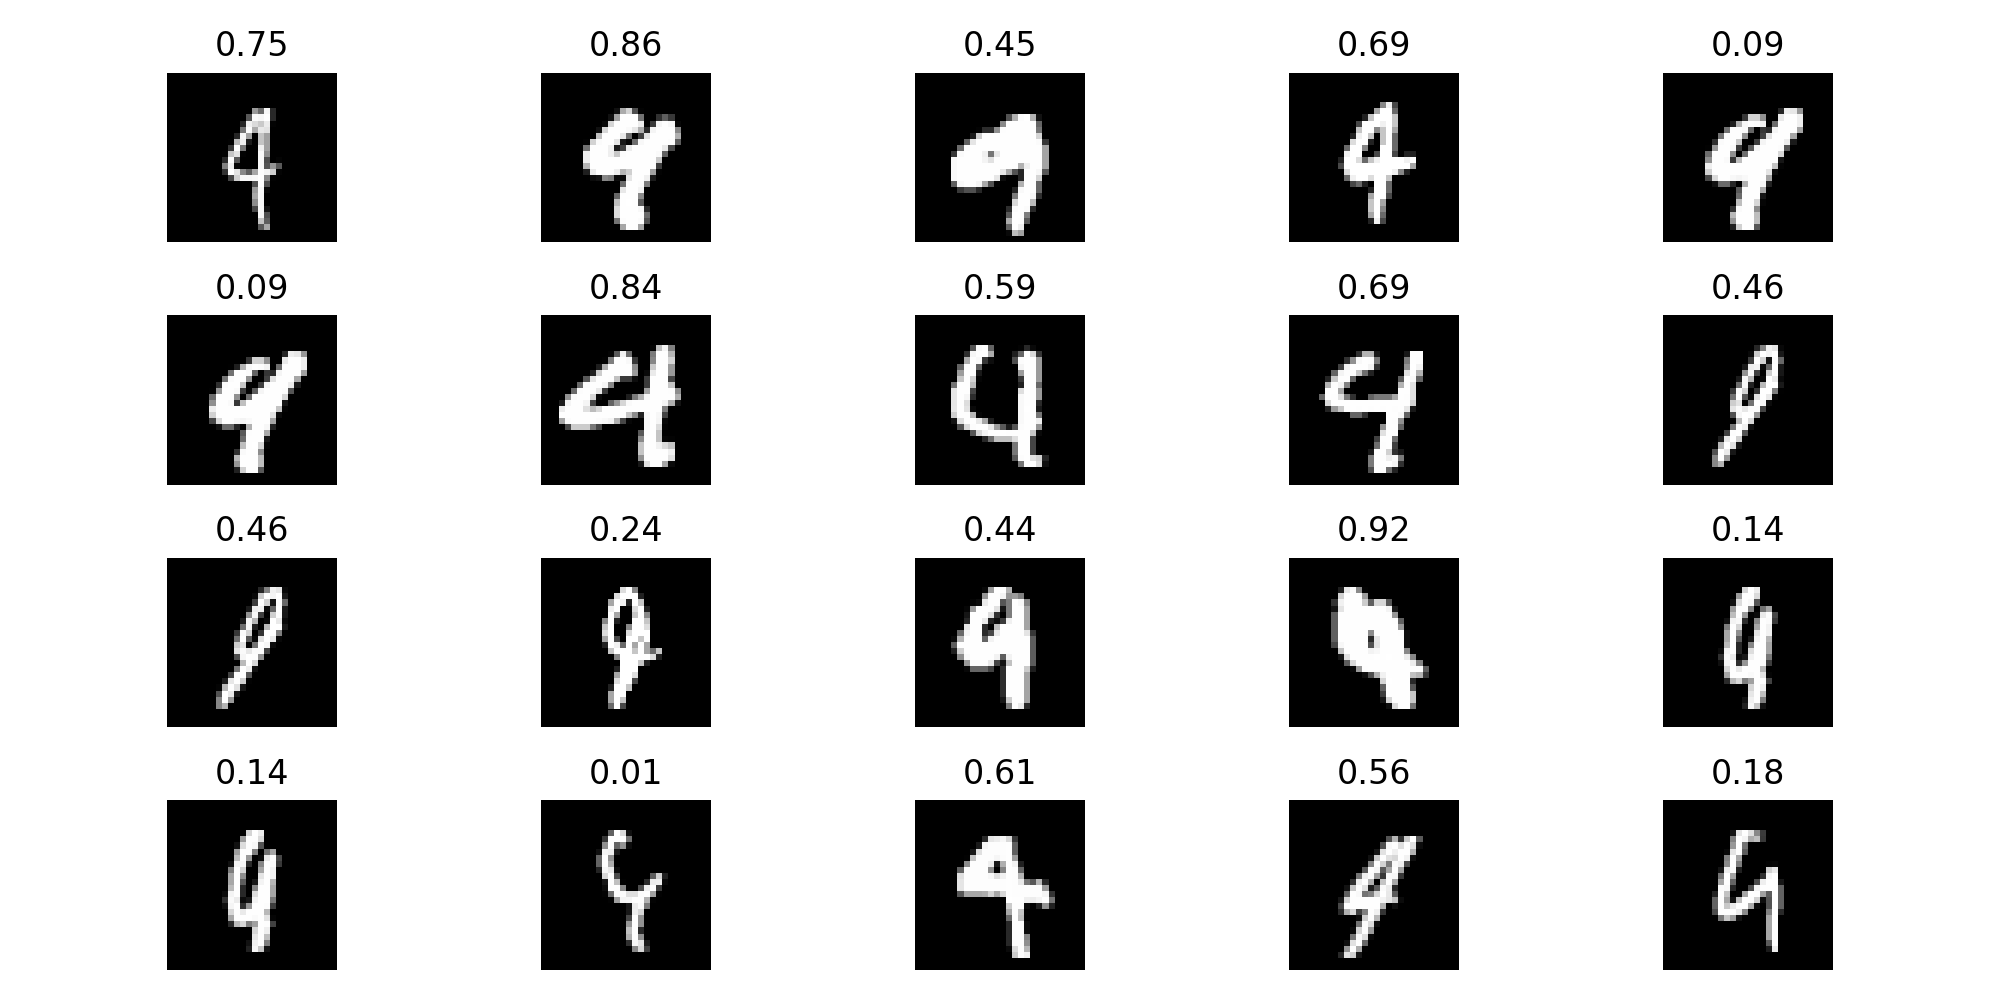

In [17]:
nerrors = len(errors)
print(nerrors)
rows = int(np.floor(np.sqrt(nerrors)))
cols = nerrors//rows
fig, ax = plt.subplots(rows, cols, figsize=(10, 5), tight_layout=True)
for i in range(rows):
    for j in range(cols):
        image = errors[i*rows+j].squeeze(0).squeeze(0).unsqueeze(2)
        conf = np.average(samples[i*rows+j])
        ax[i,j].imshow(image.numpy(), cmap=plt.cm.Greys_r)
        ax[i,j].axis('off')        
        ax[i,j].set_title(conf)

In [18]:
bins = 10
delta = 0.5
